# 1. Set up

In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

import os
import pathlib
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook

# Custom utils for rasterio
from src.data_loading.rasterio_utils import get_thumbnail, read_from_lat_lon
from src.data_loading.vector_utils import shapely_to_frame
from src.data_loading.landcover_plot_utils import classes_to_rgb
from src.utils import get_byte_size, get_osm_polygon

# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, PREFERRED_CRS

# For loading geotiff data
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS

# For loading and manipulating vector data
import geopandas as gpd
from shapely.geometry import box, Point
# For performing geospatial analysis
import pylandstats as pls

# For conveniently getting longitude, latitude from name (& geodesic distances)
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="fragmentation-analysis")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import json

# 2. Data loading

### esa-cci data

In [3]:
esa_cci_landcovers = {year: ESA_LANDCOVER_DIR / f"ESACCI-LC-L4-LCCS-Map-300m-P1Y-{year}-v2.0.7.tif" 
                      for year in range(1992, 2016)}

# Check that paths indeed exist
for path in esa_cci_landcovers.values():
    assert os.path.exists(path)
    
# Parse land cover classes:
landcover_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


## 2.1 Cut the landcover datasets to ROI

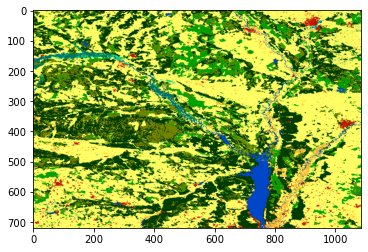

In [4]:
landcover_2015 = rasterio.open(esa_cci_landcovers[2015])

minx, miny, maxx, maxy = (28.40773, 50.54449, 31.41977, 52.54449)
lat = (miny, maxy)
lon = (minx, maxx)

plt.imshow(classes_to_rgb(read_from_lat_lon(landcover_2015, 1, lat, lon)));

In [5]:
bbox = box(minx, miny, maxx, maxy)

In [6]:
bbox_landcovers = {}

for year, data_path in tqdm.notebook.tqdm(esa_cci_landcovers.items()):
    
    out_tif = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.geojson"
    if os.path.exists(out_tif):
        logging.info(f"Processed data for {year} exists. Skipping")
        continue
    else:
        logging.info(f"Processing year {year}")
        
    # Crop to bbox around regions of interest
    with rasterio.open(data_path, "r") as data:
        out_img, out_transform = mask(data, shapes=bbox.geometry, crop=True)
        out_meta = data.meta.copy()
    
    # Update metadata for cropped region
    out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": CRS.from_string(WGS84)})
    
    # Write clipping to disk
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
        
    bbox_landcovers[year] = (out_img, out_transform)

  0%|          | 0/24 [00:00<?, ?it/s]

INFO: Processed data for 1992 exists. Skipping
INFO: Processed data for 1993 exists. Skipping
INFO: Processed data for 1994 exists. Skipping
INFO: Processed data for 1995 exists. Skipping
INFO: Processed data for 1996 exists. Skipping
INFO: Processed data for 1997 exists. Skipping
INFO: Processed data for 1998 exists. Skipping
INFO: Processed data for 1999 exists. Skipping
INFO: Processed data for 2000 exists. Skipping
INFO: Processed data for 2001 exists. Skipping
INFO: Processed data for 2002 exists. Skipping
INFO: Processed data for 2003 exists. Skipping
INFO: Processed data for 2004 exists. Skipping
INFO: Processed data for 2005 exists. Skipping
INFO: Processed data for 2006 exists. Skipping
INFO: Processed data for 2007 exists. Skipping
INFO: Processed data for 2008 exists. Skipping
INFO: Processed data for 2009 exists. Skipping
INFO: Processed data for 2010 exists. Skipping
INFO: Processed data for 2011 exists. Skipping
INFO: Processed data for 2012 exists. Skipping
INFO: Process

In [7]:
import warnings

# To avoid pylandstats from cluttering our screen with warnings.
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='once')

In [8]:
input_filepaths = [GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.geojson" for year in range(1992, 2016)]

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
cher_sta = pls.SpatioTemporalAnalysis(input_filepaths, dates=range(1992, 2016))

# 3. Metrics spatio-temporal analysis

In [17]:
class_metrics = [
   'total_area','proportion_of_landscape', 
    'edge_density','total_edge',
    'number_of_patches', 'patch_density',
    'effective_mesh_size','landscape_shape_index'
]

landscape_metrics= [
    'total_area', 'patch_density',
    'number_of_patches', 'total_edge',
    'edge_density', 'landscape_shape_index',
    'contagion', 'shannon_diversity_index',
    'effective_mesh_size'
]

cher_sta.compute_landscape_metrics_df(metrics = landscape_metrics)

metric,total_area,patch_density,number_of_patches,total_edge,edge_density,landscape_shape_index,contagion,shannon_diversity_index,effective_mesh_size
dates,,,,,,,,,
1992,0.00057,5.434673e+09,30956.0,1044.780556,1.834230e+06,110.427865,51.738081,1.885843,0.000020
1993,0.00057,5.434498e+09,30955.0,1044.691667,1.834074e+06,110.418557,51.733079,1.886157,0.000020
1994,0.00057,5.435376e+09,30960.0,1044.641667,1.833986e+06,110.413322,51.725105,1.886592,0.000020
1995,0.00057,5.384463e+09,30670.0,1041.558333,1.828573e+06,110.090460,52.127206,1.873450,0.000021
1996,0.00057,5.386394e+09,30681.0,1041.605556,1.828655e+06,110.095404,52.154089,1.872857,0.000021
1997,0.00057,5.391485e+09,30710.0,1042.694444,1.830567e+06,110.209424,52.177165,1.871906,0.000020
1998,0.00057,5.395699e+09,30734.0,1043.722222,1.832372e+06,110.317045,52.160487,1.872329,0.000020
1999,0.00057,5.401843e+09,30769.0,1042.133333,1.829582e+06,110.150669,52.361175,1.865631,0.000020
2000,0.00057,5.410446e+09,30818.0,1043.200000,1.831455e+06,110.262362,52.368442,1.865001,0.000020


In [18]:
cher_sta.compute_class_metrics_df(metrics = class_metrics)

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


metric           total_area  proportion_of_landscape   edge_density  \
class_val dates                                                       
10        1992     0.000209                36.761383  931444.966432   
          1993     0.000209                36.756235  931337.679015   
          1994     0.000209                36.749598  931225.514898   
          1995     0.000215                37.694729  937916.348326   
          1996     0.000215                37.801746  938925.825382   
...                     ...                      ...            ...   
210       2011     0.000014                 2.419385   69244.273941   
          2012     0.000014                 2.420063   69283.287547   
          2013     0.000014                 2.425888   69215.013736   
          2014     0.000014                 2.432254   69117.479721   
          2015     0.000014                 2.432254   69117.479721   

metric           total_edge  number_of_patches  patch_density  \
class_val dates                                                 
10        1992   530.552778             2551.0   4.478567e+08   
          1993   530.491667             2551.0   4.478567e+08   
          1994   530.427778             2554.0   4.483834e+08   
          1995   534.238889             2224.0   3.904482e+08   
          1996   534.813889             2184.0   3.834257e+08   
...                     ...                ...            ...   
210       2011    39.441667              489.0   8.584944e+07   
          2012    39.463889              488.0   8.567388e+07   
          2013    39.425000              483.0   8.479607e+07   
          2014    39.369444              472.0   8.286490e+07   
          2015    39.369444              472.0   8.286490e+07   

metric           effective_mesh_size  landscape_shape_index  
class_val dates                                              
10        1992          1.790761e-05              92.340691  
          1993          1.790306e-05              92.330134  
          1994          1.789535e-05              92.318618  
          1995          1.847269e-05              91.755682  
          1996          1.853598e-05              91.770104  
...                              ...                    ...  
210       2011          1.393215e-07              26.570896  
          2012          1.394900e-07              26.585821  
          2013          1.466017e-07              26.559701  
          2014          1.640503e-07              26.522388  
          2015          1.640503e-07              26.522388  

[456 rows x 8 columns]

### Legend for class value:

|  Class Value   | Label  |
|  :----:  | :----:  |
| 10  | Cropland, rainfed |
| 11  | Herbaceous cover |
| 30 | Mosaic cropland (>50%)/natural vegetation (tree, shrub, herbaceous cover)(<50%) |
| 40 | Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%) |
| 60 | Tree cover, broadleaved, deciduous, closed to open (>15%) |
| 61 | Tree cover, broadleaved, deciduous, closed (>40%) |
| 70 | Tree cover, :needleleaved, evergreen, closed to open (>15%) |
| 90 | Tree cover, mixed leaf type (broadleaved and needleleaved) |
| 100 | Mosaic tree and shrub (>50%) / herbaceous cover (<50%) |
| 110 | Mosaic herbaceous cover (>50%) / tree and shrub (<50%) |
| 130 | Grassland |
| 150 | Sparse vegetation (tree, shrub, herbaceous cover) (<15%) |
| 160 | Tree cover, flooded, fresh or brakish water |
| 180 | Shrub or herbaceous cover, flooded, fresh/saline/brakish water |
| 190 | Urban areas |
| 200 | Bare areas |
| 210 | Water bodies |

## 3.1 Plotting the temporal variation 

### 3.1.1 The temporal variation for the rainfed cropland (class_val = 10) and herbaceous area (class_val = 11) (as examples)

In [25]:
def plot_metrics_chernobyl(classVal):
    '''Plot the temporal variation of class metrics for different class value'''
    fig = plt.figure(figsize=(7,35))
    plt.xticks([])
    plt.yticks([])
    plt.title('Temporal variation of metrics for class_val%s'%(classVal))
    for i, metric in enumerate(class_metrics, start=1):
        ax = fig.add_subplot(8, 1, i)
        cher_sta.plot_metric(metric, class_val=classVal, ax=ax)
        ax.margins(y=.5)
        

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


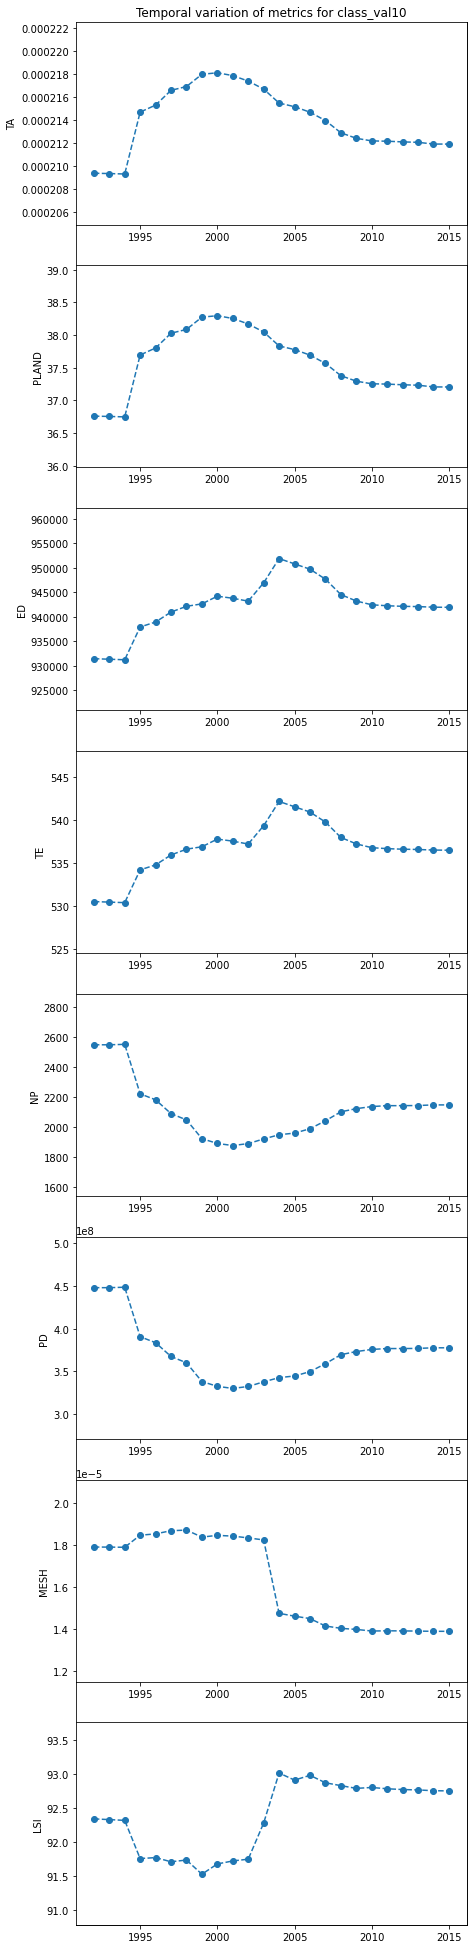

In [26]:
plot_metrics_chernobyl(10)

Figures show the temporal variation of the metrics for class 10, the rainfed cropland.

"TA" means total area of the rainfed cropland. From the figure, it reached the peak around 2000. "PLAND" means proportion of landscape,measuring the proportional abundance of a particular class within the landscape. "ED" and "TE" are edge density and total edge, respectively.They measuring the edge length for this class level. "NP" and "PD" measure the number of patches and the patch density for the rainfed cropland. Around 2000, they were down to the bottom, which might be caused by the merge of several small patches. "LSI" represents the landscape shape index and provides a standardized measure of total edge or edge density that adjusts for the size of the landscape. According to the introduction of FRAGSTATS, as LSI increases, the patches belonged to the same class become increasingly disaggregated. From the figure, during the period of 1995 to 2003, the cropland tended to be aggregated, approving the guess of the merging patches. After 2005, the patches became disaggregated again.

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


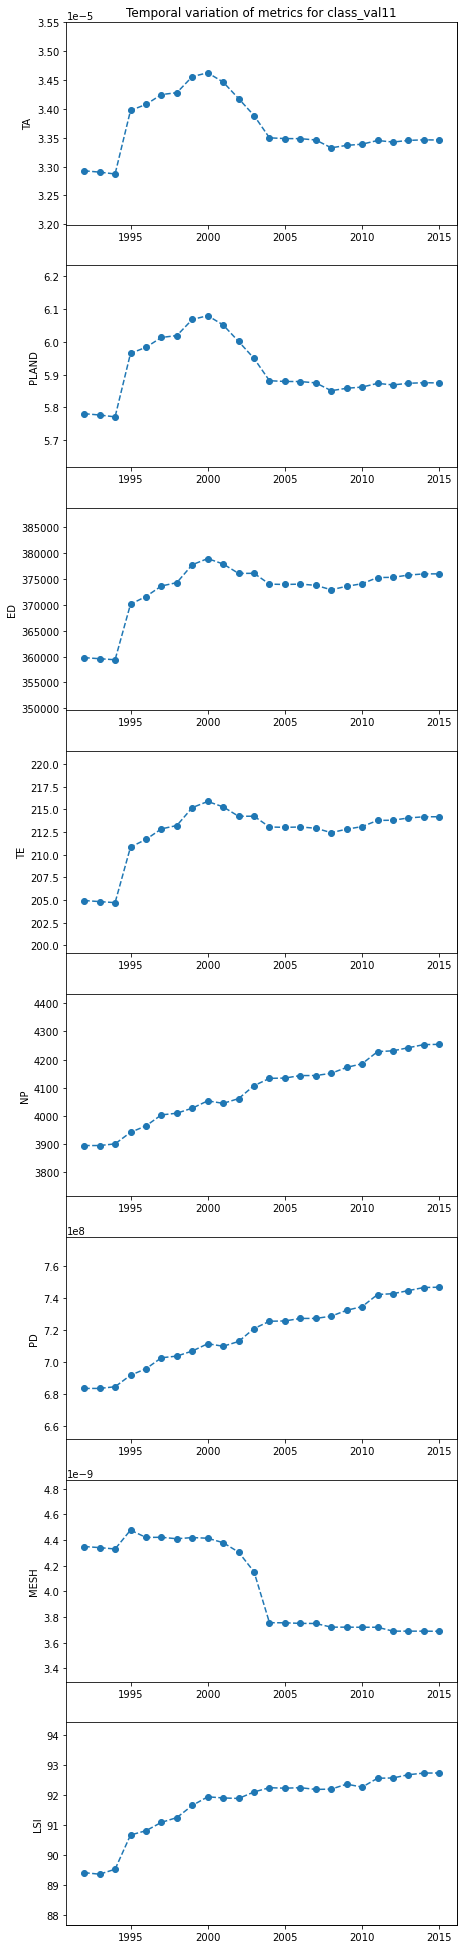

In [27]:
plot_metrics_chernobyl(11)

Figure shows the temporal variation of class_val = 11, herbaceous cover

### 3.1.2 The temporal variation for urban area (class_val = 190)

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


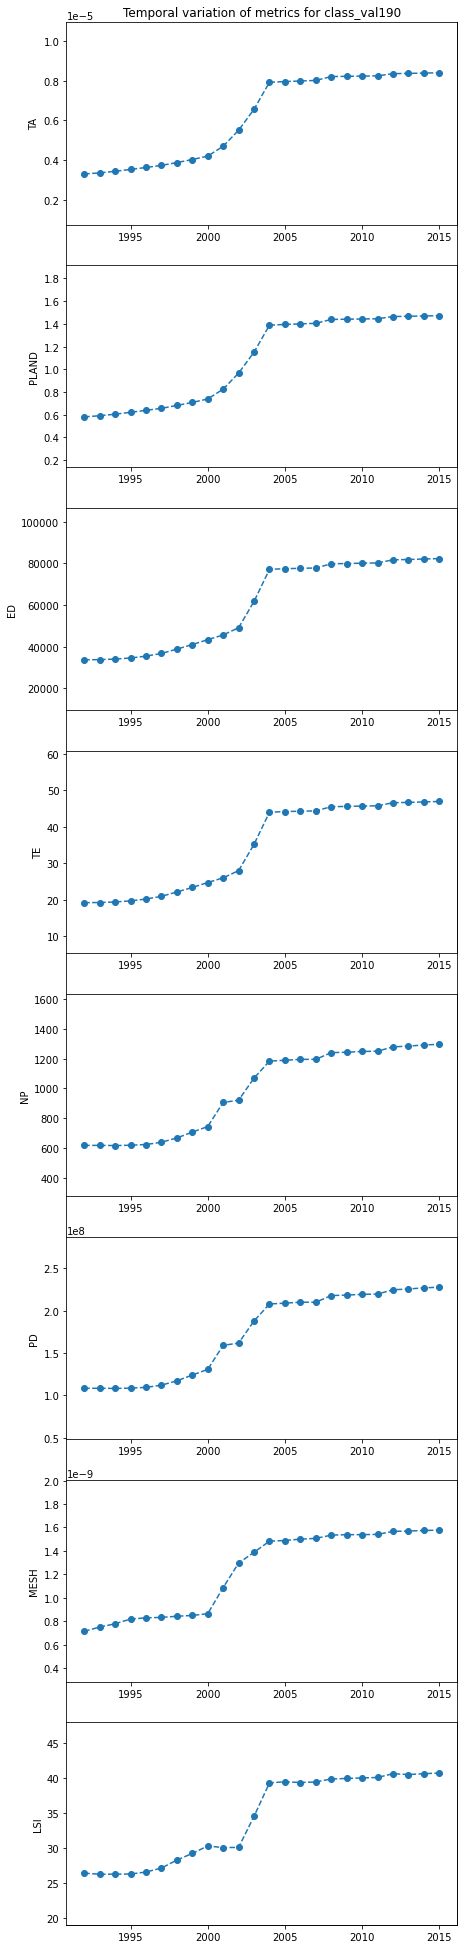

In [28]:
plot_metrics_chernobyl(190)

Figures show the temporal variation for urabn areas.

From the figures, it seems that there was a increasing trend for urban areas. Especially, from 2000 to 2005, this whole region experienced a fast growth for the urban parts. 

### 3.1.3 The temporal variation for bare areas (class_val = 200)

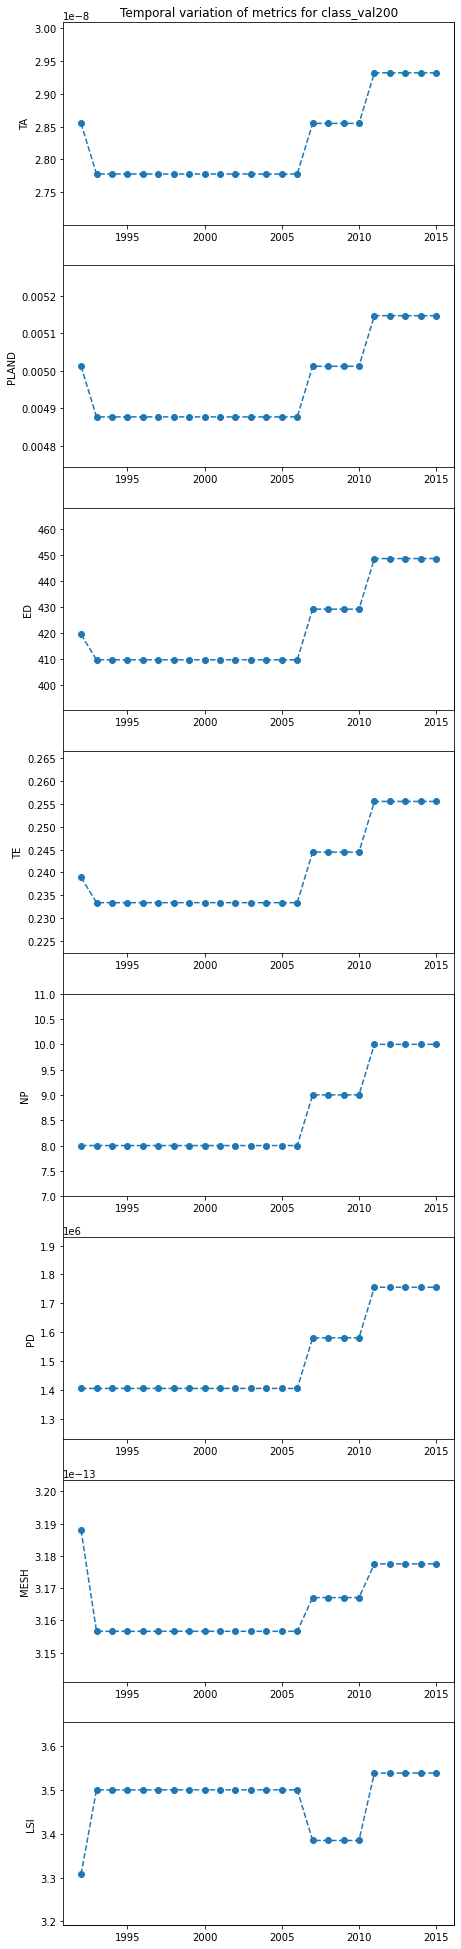

In [30]:
plot_metrics_chernobyl(200)

Figures show the temporal variation of bare areas.

### 3.1.2 The temporal variation for landscape level

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


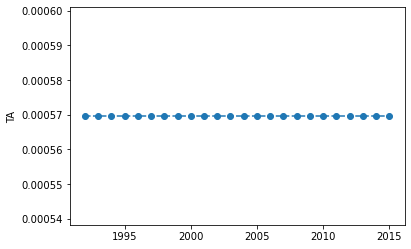

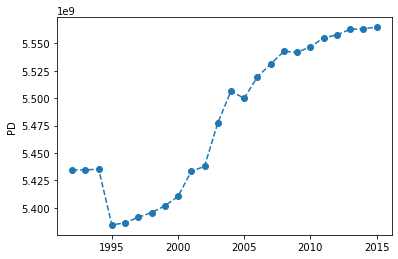

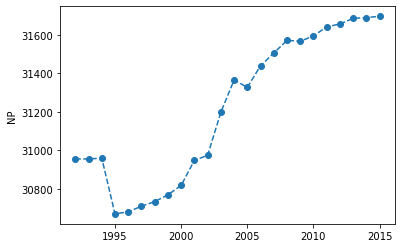

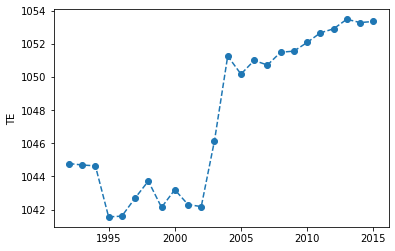

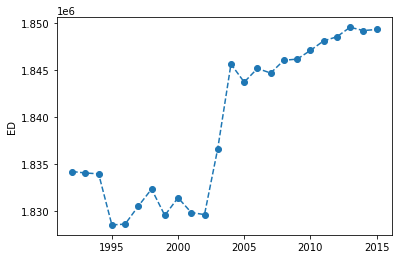

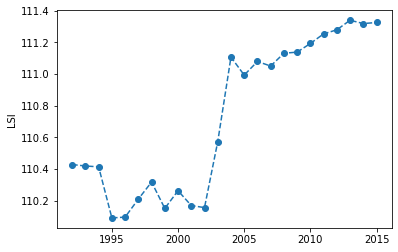

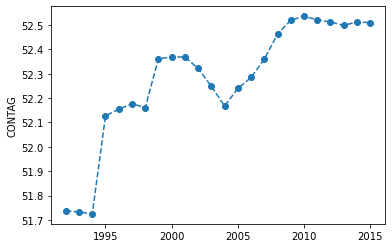

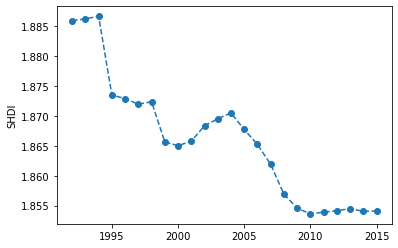

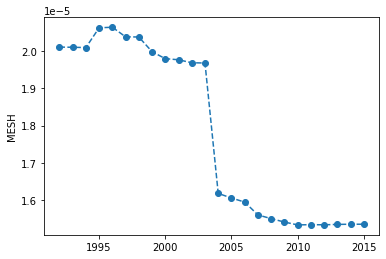

In [24]:
for i, metric in enumerate(landscape_metrics, start=1):
    
    cher_sta.plot_metric(metric)
    

"SHDI" represents Shannon's diversity index, measuring of diversity that reflects the number of classes present in the landscape as well as the relative abundance of each class. The more diversity the land cover is, the higher SHDI is. As shown from the figure, there was a decreasing trend of SHDI, meaning the less diversity of the land cover. This might also represent the slightly reduced biodiversity of this region from 1995 to 2015. 

"MESH" represents effective mesh size. The previous research said that the smaller the effective mesh size, the more fragmented the landscape. The figure demonstrates that the effective mesh size had experienced a downward trend since 1996. Especially, there was a big drop between 2003 and 2004. The sign is likely to reveal the fragmentatation of this region, which is opposed to our hypothesis: the defragmentation of Chernobyl region.

#### One question for the analysis: Is it necessary to change the CRD of the data? (from WGS84 to UTM35)